# 导包

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
import lightgbm as lgb
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import warnings

warnings.filterwarnings('ignore')

# 加载数据

## 特征工程（未降维数据）

In [2]:
all_data = pd.read_csv('./processed_zhengqi_data2.csv')

# 训练数据
cond = all_data['label'] == 'train'
train_data = all_data[cond]
train_data.drop(labels='label', axis=1, inplace = True)

# 
X = train_data.drop(labels = 'target', axis = 1)
y = train_data['target']
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.2)

#测试提交数据
cond2 = all_data['label'] == 'test'
submit_test = all_data[cond2]
submit_test.drop(labels=['label', 'target'], axis = 1)

,V0,V1,V2,V3,V4,V6,V7,V8,V10,V12,...,V20,V23,V24,V27,V29,V30,V31,V35,V36,V37
2784,3.776075,7.069312,0.893000,0.800397,1.178315,6.276006,8.630500,5.173098,0.364102,1.725493,...,0.300204,9.945476,0.007955,9383.393900,0.293543,1.748218,21.107979,7.279759,0.324214,0.552931
2785,3.394817,7.476449,0.886219,0.800397,1.084765,6.097242,8.379541,4.381098,0.367358,1.794980,...,0.298573,9.898099,0.009014,9597.799540,0.293543,2.164438,23.641827,7.916062,0.377974,0.516601
2786,2.903231,5.602648,0.866625,0.825062,1.022993,6.091635,8.379541,4.185449,0.525979,1.627825,...,0.294187,9.904011,0.009014,8024.976727,0.259317,1.782136,23.924248,7.916062,0.520486,0.575907
2787,3.319038,6.761318,0.882530,0.826367,0.979641,6.060876,8.426660,4.661140,0.361666,1.513929,...,0.297481,9.874484,0.397549,9324.646174,0.259317,2.590345,23.169680,7.916062,0.305358,0.553313
2788,3.654839,7.246254,1.031245,0.826367,1.030555,5.878963,8.396650,4.973238,0.417456,1.500806,...,0.307059,9.892191,0.398270,9609.845895,0.228053,1.933972,26.119386,7.916062,0.409456,0.438546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4704,1.507318,2.366075,0.192182,0.700533,1.179061,0.138338,0.043709,0.440800,0.004467,1.754458,...,0.311164,3.469953,0.184800,749.697250,0.302625,0.002497,0.448108,2.996210,0.005636,0.579449
4705,0.607637,0.591671,0.100980,0.552034,0.623189,0.122522,0.084880,0.334212,0.008009,0.766166,...,0.282567,3.615372,0.291031,649.875342,0.377223,1.285751,0.000000,2.996210,0.005636,0.656833
4706,0.648457,0.535177,0.137667,0.705981,0.653005,0.308269,0.291171,0.133988,0.007462,1.000486,...,0.323910,4.724425,0.591230,851.669065,0.329385,1.800831,0.324084,3.987778,0.008216,0.705772
4707,0.625626,0.496193,0.160569,0.638362,0.653539,0.497144,0.493672,0.238140,0.003246,0.862510,...,0.244579,4.727569,0.531587,1091.648345,0.313149,2.671518,0.722675,3.987778,0.007570,0.683533


## 特征工程（未降维数据）

In [3]:
X_pca = np.load('./train_data_pca.npz')['X_train']
y_pca = np.load('./train_data_pca.npz')['y_train']

X_train_pca,X_valid_pca,y_train_pca,y_valid_pca = train_test_split(X_pca,y_pca,test_size=0.2)

submit_test_pca = np.load('./test_data_pca.npz')['X_test']

# 网格搜索GridSearchCV

In [4]:
def train_model(model, param_grid = [], X=[], y=[], splits=5, repeats=5):
    
    #创建网格交叉
    rkfold = RepeatedKFold(n_splits=splits, n_repeats=repeats)
    
    #设置网格搜索
    gsearch = GridSearchCV(model, param_grid, cv=rkfold,
                          scoring='neg_mean_squared_error',
                          verbose=1,return_train_score=True)
    
    #网格搜索训练
    gsearch.fit(X, y)
    
    #提取最优算法
    model = gsearch.best_estimator_
    
    #获取最优算法平均得分和标准差
    best_idx = gsearch.best_index_ #最优算法索引
    grid_results = pd.DataFrame(gsearch.cv_results_)
    cv_mean = abs(grid_results.loc[best_idx,'mean_test_score'])
    cv_std = grid_results.loc[best_idx,'std_test_score']
    
    #平均值和方差数据合并
    cv_score = pd.Series({'mean':cv_mean,'std':cv_std})
    
    #预测
    y_pred = model.predict(X)
    
    #输出模型评价指标
    print('------------------------')
    print(model)
    print('------------------------')
    print('score=', model.score(X,y))
    print('mse=', mean_squared_error(y,y_pred))
    print('cross_val:mean=',cv_mean, ',std=', cv_std)
    
    #残差数据可视化
    y_pred= pd.Series(y_pred, index=y.index)
    resid = y-y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()
    z = (resid-mean_resid)/std_resid
    n_outliers = sum(abs(z)>3)
    
    plt.figure(figsize=(15,5))
    ax1 = plt.subplot(131)
    plt.plot(y,y_pred, '.')
    plt.xlabel('y')
    plt.ylabel('y_pred')
    plt.title('corr = {:.3f}'.format(np.corrcoef(y,y_pred)[0][1]))
    
    ax2 = plt.subplot(132)
    plt.plot(y,y_pred, '.')
    plt.xlabel('y')
    plt.ylabel('y-y_pred')
    plt.title('std_resid = {:.3f}'.format(std_resid))
    
    ax3 = plt.subplot(133)
    z.plot.hist(bins=50, ax=ax3)
    plt.xlabel('z')
    plt.title('{:.0f} sample with z>3'.format(n_outliers))
    
    return model, cv_score, grid_results

# 非降维数据

In [5]:
#可选模型
opt_models= dict()
#记录模型表现
score_models = pd.DataFrame(columns=['mean','std'])

splits = 5
repeats = 5

## 岭回归

Fitting 25 folds for each of 19 candidates, totalling 475 fits
------------------------
Ridge(alpha=0.08)
------------------------
score= 0.890204861361265
mse= 0.10091918307578285
cross_val:mean= 0.1036652973625232 ,std= 0.004783506509049589


Text(0, 0.5, 'score')

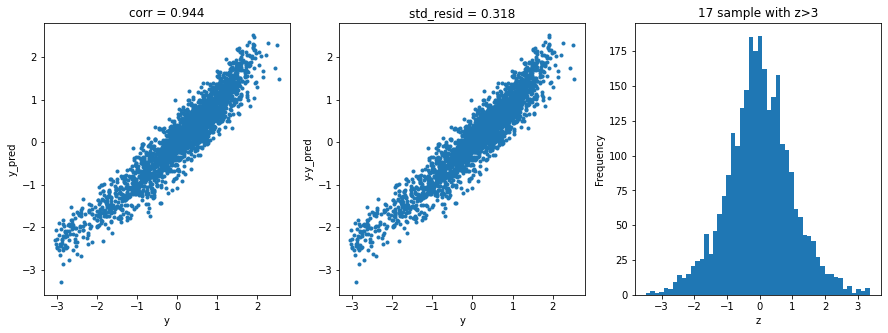

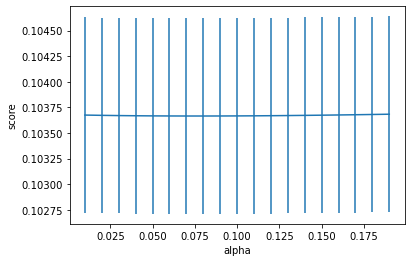

In [6]:
model = 'Ridge'
opt_models[model] = Ridge()

alphas = np.arange(0.01,0.2,0.01)
param_grid = {'alpha': alphas}
opt_models[model],cv_score,grid_results = train_model(opt_models[model],
                                                     param_grid = param_grid,
                                                     X=X,y=y,
                                                     splits=splits,
                                                     repeats=repeats)
cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(alphas,abs(grid_results['mean_test_score']),
            abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('alpha')
plt.ylabel('score')

In [7]:
score_models

,mean,std
Ridge,0.103665,0.004784


In [8]:
grid_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split17_train_score,split18_train_score,split19_train_score,split20_train_score,split21_train_score,split22_train_score,split23_train_score,split24_train_score,mean_train_score,std_train_score
0,0.002559,0.001651,0.001280,0.000449,0.01,{'alpha': 0.01},-0.095637,-0.102614,-0.099284,-0.109990,...,-0.100418,-0.099611,-0.101445,-0.098546,-0.100929,-0.101376,-0.102008,-0.100077,-0.100607,0.001159
1,0.002003,0.000633,0.001080,0.000271,0.02,{'alpha': 0.02},-0.095641,-0.102602,-0.099271,-0.109987,...,-0.100419,-0.099612,-0.101446,-0.098546,-0.100930,-0.101376,-0.102009,-0.100078,-0.100608,0.001159
2,0.001920,0.000483,0.001161,0.000367,0.03,{'alpha': 0.03},-0.095645,-0.102591,-0.099258,-0.109985,...,-0.100421,-0.099613,-0.101447,-0.098547,-0.100932,-0.101377,-0.102010,-0.100079,-0.100609,0.001159
3,0.001800,0.000633,0.001040,0.000196,0.04,{'alpha': 0.04},-0.095650,-0.102580,-0.099245,-0.109983,...,-0.100423,-0.099615,-0.101448,-0.098549,-0.100933,-0.101378,-0.102012,-0.100081,-0.100610,0.001159
4,0.001960,0.000445,0.001240,0.000427,0.05,{'alpha': 0.05},-0.095654,-0.102571,-0.099233,-0.109981,...,-0.100427,-0.099617,-0.101450,-0.098551,-0.100936,-0.101379,-0.102015,-0.100083,-0.100612,0.001159
5,0.001961,0.000528,0.001160,0.000463,0.06,{'alpha': 0.060000000000000005},-0.095659,-0.102562,-0.099222,-0.109979,...,-0.100430,-0.099620,-0.101452,-0.098553,-0.100938,-0.101380,-0.102018,-0.100085,-0.100615,0.001159
6,0.002199,0.000490,0.001120,0.000431,0.07,{'alpha': 0.06999999999999999},-0.095665,-0.102554,-0.099211,-0.109978,...,-0.100435,-0.099622,-0.101455,-0.098555,-0.100941,-0.101382,-0.102021,-0.100088,-0.100617,0.001159
7,0.001800,0.000490,0.001120,0.000431,0.08,{'alpha': 0.08},-0.095670,-0.102546,-0.099201,-0.109977,...,-0.100439,-0.099625,-0.101458,-0.098558,-0.100945,-0.101384,-0.102024,-0.100091,-0.100620,0.001159
8,0.001960,0.000446,0.001039,0.000196,0.09,{'alpha': 0.09},-0.095676,-0.102539,-0.099191,-0.109977,...,-0.100444,-0.099629,-0.101461,-0.098561,-0.100948,-0.101386,-0.102028,-0.100094,-0.100623,0.001159
9,0.002072,0.000395,0.001160,0.000367,0.1,{'alpha': 0.09999999999999999},-0.095681,-0.102533,-0.099181,-0.109976,...,-0.100450,-0.099632,-0.101464,-0.098564,-0.100952,-0.101388,-0.102033,-0.100097,-0.100627,0.001159


## 劳索回归

Fitting 25 folds for each of 23 candidates, totalling 575 fits
------------------------
Lasso(alpha=0.00022000000000000003)
------------------------
score= 0.889968274907167
mse= 0.10113664362977805
cross_val:mean= 0.10379075441039837 ,std= 0.008299576311438038


Text(0, 0.5, 'mse')

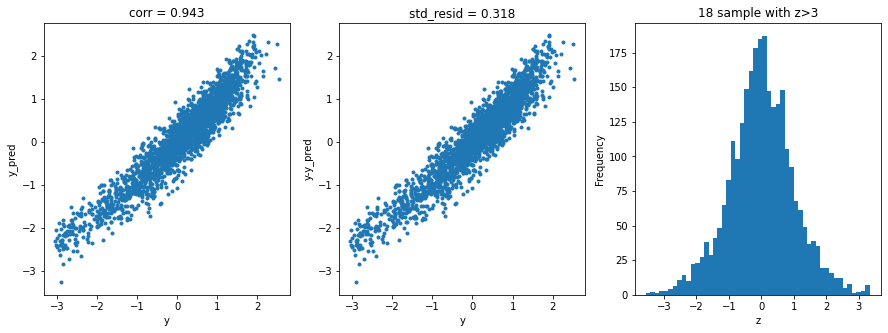

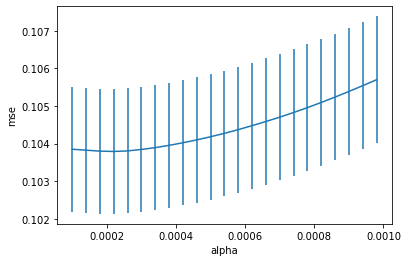

In [9]:
model = 'Lasso'

opt_models[model] = Lasso()
alphas = np.arange(1e-4,1e-3,4e-5)
param_grid = {'alpha':alphas}

opt_models[model], cv_score, grid_results = train_model(opt_models[model],
                                                       param_grid=param_grid,
                                                       X=X,y=y,
                                                       splits=splits,repeats=repeats)

cv_score.name = model
score_models.append(cv_score)

plt.figure()
plt.errorbar(alphas, abs(grid_results['mean_test_score']),
            abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('alpha')
plt.ylabel('mse')

In [10]:
grid_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split17_train_score,split18_train_score,split19_train_score,split20_train_score,split21_train_score,split22_train_score,split23_train_score,split24_train_score,mean_train_score,std_train_score
0,0.006762,0.000650,0.001041,0.000446,0.0001,{'alpha': 0.0001},-0.093869,-0.092024,-0.110742,-0.107151,...,-0.104332,-0.102118,-0.098818,-0.101078,-0.103196,-0.102167,-0.099421,-0.097178,-0.100673,0.002024
1,0.006517,0.000639,0.001197,0.000402,0.00014,{'alpha': 0.00014000000000000001},-0.093594,-0.091989,-0.110746,-0.107208,...,-0.104400,-0.102139,-0.098869,-0.101102,-0.103242,-0.102188,-0.099509,-0.097267,-0.100729,0.002031
2,0.006283,0.000666,0.000875,0.000323,0.00018,{'alpha': 0.00018000000000000004},-0.093347,-0.091994,-0.110758,-0.107267,...,-0.104432,-0.102167,-0.098900,-0.101130,-0.103271,-0.102216,-0.099561,-0.097387,-0.100781,0.002032
3,0.006234,0.000515,0.000802,0.000491,0.00022,{'alpha': 0.00022000000000000003},-0.093128,-0.092010,-0.110777,-0.107335,...,-0.104471,-0.102203,-0.098939,-0.101164,-0.103306,-0.102251,-0.099596,-0.097467,-0.100834,0.002032
4,0.006520,0.000574,0.000920,0.000392,0.00026,{'alpha': 0.00026000000000000003},-0.092985,-0.092033,-0.110804,-0.107413,...,-0.104519,-0.102245,-0.098986,-0.101205,-0.103348,-0.102293,-0.099638,-0.097509,-0.100887,0.002035
5,0.006321,0.000554,0.001002,0.000014,0.0003,{'alpha': 0.00030000000000000003},-0.093007,-0.092062,-0.110838,-0.107499,...,-0.104575,-0.102294,-0.099039,-0.101253,-0.103397,-0.102342,-0.099687,-0.097558,-0.100938,0.002035
6,0.006359,0.000630,0.000886,0.000434,0.00034,{'alpha': 0.0003400000000000001},-0.093035,-0.092098,-0.110880,-0.107595,...,-0.104639,-0.102351,-0.099094,-0.101307,-0.103453,-0.102398,-0.099742,-0.097615,-0.100995,0.002034
7,0.006358,0.000622,0.000920,0.000392,0.00038,{'alpha': 0.0003800000000000001},-0.093069,-0.092140,-0.110929,-0.107700,...,-0.104703,-0.102414,-0.099156,-0.101369,-0.103517,-0.102462,-0.099805,-0.097678,-0.101059,0.002033
8,0.006318,0.000614,0.000758,0.000426,0.00042,{'alpha': 0.00042000000000000007},-0.093110,-0.092189,-0.110986,-0.107814,...,-0.104774,-0.102485,-0.099225,-0.101438,-0.103587,-0.102532,-0.099875,-0.097748,-0.101130,0.002033
9,0.006355,0.000679,0.000880,0.000431,0.00046,{'alpha': 0.00046000000000000007},-0.093158,-0.092244,-0.111051,-0.107938,...,-0.104852,-0.102562,-0.099301,-0.101513,-0.103665,-0.102609,-0.099952,-0.097825,-0.101207,0.002032
